In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf


print(tf.test.is_gpu_available())
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

C:\Users\witlab\anaconda3\envs\gpu_test_python3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\witlab\anaconda3\envs\gpu_test_python3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\witlab\anaconda3\envs\gpu_test_python3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\witlab\anaconda3\envs\

True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18319562666874188809
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 78607156
locality {
  bus_id: 1
}
incarnation: 6752597668346512172
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# image_path = r'image\auto_intg\preprocess\train_image_20240228'
image_path=r'image\auto_intg\sensor_add_change_position\preprocess_no_cut\train_image_20240405_afternoon'

image_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]

images = []
for file in image_files:
    img = cv2.imread(os.path.join(image_path, file))
    if img is None:
        print(f"{file} 읽을 수 없음")
        continue

    img = img / 255.0  # 0~1로 정규화
    images.append(img)

images = np.array(images)
print(images.shape)

(4981, 224, 224, 3)


In [3]:
import pandas as pd

excel_path = 'data/train_data_20240307-20240402_20240405_sun_info_afternoon.xlsx'
df = pd.read_excel(excel_path, engine='openpyxl')

# illum_columns = [f'new_illum_{i}' for i in range(1, 13)]
illum_columns = [f'new_illum_{i}' for i in [10, 11, 12, 4, 5, 6, 1, 2, 3, 7, 8, 9]]


# Extract output (illum) columns
target_data = (df[illum_columns]).to_numpy()
target_data[target_data < 0] = 0
print(target_data.shape)

(4981, 12)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, target_data, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training data shape: (3984, 224, 224, 3)
Testing data shape: (997, 224, 224, 3)
Training target shape: (3984, 12)
Testing target shape: (997, 12)


In [5]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define your CNN model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(12))


# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
model.summary()


early_stopping_cb = EarlyStopping(patience =20, monitor = 'val_loss')
checkpoint_cb = ModelCheckpoint("model/cnn_best_model_20240417_tuning_1_창측제외_테스트변경_오후만.h5", monitor='val_loss', save_best_only=True, mode='min')


history = model.fit(X_train, y_train, epochs=500, batch_size=4, validation_data=(X_test, y_test), callbacks=[early_stopping_cb,checkpoint_cb])

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 512)       1180160   
__________

3984/3984 [==============================] - 89s - loss: 17.8935 - acc: 0.9011 - val_loss: 18.7752 - val_acc: 0.9027
Epoch 42/500
3984/3984 [==============================] - 89s - loss: 17.3052 - acc: 0.9096 - val_loss: 18.6256 - val_acc: 0.9288
Epoch 43/500
3984/3984 [==============================] - 90s - loss: 17.8198 - acc: 0.9059 - val_loss: 15.7088 - val_acc: 0.9127
Epoch 44/500
3984/3984 [==============================] - 89s - loss: 17.3179 - acc: 0.9066 - val_loss: 15.8601 - val_acc: 0.9147
Epoch 45/500
3984/3984 [==============================] - 89s - loss: 16.5831 - acc: 0.9101 - val_loss: 18.0317 - val_acc: 0.9047
Epoch 46/500
3984/3984 [==============================] - 89s - loss: 16.9073 - acc: 0.9101 - val_loss: 18.8087 - val_acc: 0.9127
Epoch 47/500
3984/3984 [==============================] - 89s - loss: 15.6952 - acc: 0.9061 - val_loss: 18.4769 - val_acc: 0.9097
Epoch 48/500
3984/3984 [==============================] - 90s - loss: 16.1300 - acc: 0.9147 - val_loss:

3984/3984 [==============================] - 89s - loss: 10.6314 - acc: 0.9287 - val_loss: 12.7249 - val_acc: 0.9208
Epoch 105/500
3984/3984 [==============================] - 89s - loss: 10.9316 - acc: 0.9227 - val_loss: 21.2921 - val_acc: 0.9157
Epoch 106/500
3984/3984 [==============================] - 89s - loss: 11.2117 - acc: 0.9272 - val_loss: 13.6335 - val_acc: 0.9388
Epoch 107/500
3984/3984 [==============================] - 89s - loss: 10.7705 - acc: 0.9340 - val_loss: 15.3247 - val_acc: 0.9348
Epoch 108/500
3984/3984 [==============================] - 89s - loss: 12.0923 - acc: 0.9244 - val_loss: 12.4926 - val_acc: 0.9378
Epoch 109/500
3984/3984 [==============================] - 89s - loss: 10.9818 - acc: 0.9350 - val_loss: 17.1675 - val_acc: 0.9398
Epoch 110/500
3984/3984 [==============================] - 89s - loss: 11.0722 - acc: 0.9290 - val_loss: 13.9978 - val_acc: 0.9248
Epoch 111/500
3984/3984 [==============================] - 89s - loss: 11.2285 - acc: 0.9315 - va

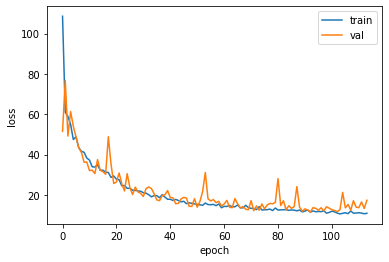

In [6]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 2024.03.13 데이터로 성능 테스트

In [11]:
test_image_path = r'image\auto_intg\preprocess_no_cut\20240407'
test_image_files = [f for f in os.listdir(test_image_path) if f.endswith('.jpg')]

test_images = []
for file in test_image_files:
    img = cv2.imread(os.path.join(test_image_path, file))
    if img is None:
        print(f"{file} 읽을 수 없음")
        continue

    img = img / 255.0  # 0~1로 정규화
    test_images.append(img)

test_images = np.array(test_images)
print(test_images.shape)

(735, 224, 224, 3)


In [12]:
test_excel_path = 'data/test_data_20240407.xlsx'
test_df = pd.read_excel(test_excel_path, engine='openpyxl')

illum_columns = [f'new_illum_{i}' for i in [10, 11, 12, 4, 5, 6, 1, 2, 3, 7, 8, 9]]

# Extract output (illum) columns
test_target_data = (test_df[illum_columns]).to_numpy()
test_target_data[test_target_data < 0] = 0
print(test_target_data.shape)

pred = model.predict(test_images)

(735, 12)


In [13]:
# Create DataFrames from the arrays
actual_df = pd.DataFrame(test_target_data, columns=[f'Actual_Illum_{i}' for i in [10, 11, 12, 4, 5, 6, 1, 2, 3, 7, 8, 9]])
predicted_df = pd.DataFrame(pred, columns=[f'Predicted_Illum_{i}' for i in [10, 11, 12, 4, 5, 6, 1, 2, 3, 7, 8, 9]])

# Concatenate the DataFrames horizontally
comparison_data = pd.concat([actual_df, predicted_df], axis=1)

# Save the DataFrame to an Excel file
excel_output_path = 'cnn_results_20240407_test_20240417_tuning1_테스트변경_오후만.xlsx'
comparison_data.to_excel(excel_output_path, index=False)

print(f"Comparison results saved to {excel_output_path}")

Comparison results saved to cnn_results_20240407_test_20240417_tuning1_테스트변경_오후만.xlsx


In [14]:
from sklearn.metrics import r2_score, mean_absolute_error
r_squared = r2_score(test_target_data, pred)
mae = mean_absolute_error(test_target_data, pred)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r_squared)

Mean Absolute Error (MAE): 40.08672732875436
R-squared (R²): 0.9231664862759811
